<a href="https://colab.research.google.com/github/jameschapman19/cca_zoo/blob/master/tutorial_notebooks/cca_zoo_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cca-zoo[deep,probabilistic]
!pip install scipy --upgrade

Requirement already up-to-date: scipy in /usr/local/lib/python3.7/dist-packages (1.6.3)


In [2]:
# Imports
import numpy as np
from cca_zoo.data import Noisy_MNIST_Dataset
import itertools
import os
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torch import optim

# Load MNIST Data
os.chdir('..')
N = 500
dataset = Noisy_MNIST_Dataset(mnist_type='FashionMNIST', train=True)
ids = np.arange(min(2 * N, len(dataset)))
np.random.shuffle(ids)
train_ids, val_ids = np.array_split(ids, 2)
val_dataset = Subset(dataset, val_ids)
train_dataset = Subset(dataset, train_ids)
test_dataset = Noisy_MNIST_Dataset(mnist_type='FashionMNIST', train=False)
test_ids = np.arange(min(N, len(test_dataset)))
np.random.shuffle(test_ids)
test_dataset = Subset(test_dataset, test_ids)
train_view_1, train_view_2, train_rotations, train_OH_labels, train_labels = train_dataset.dataset.to_numpy(
    train_dataset.indices)
val_view_1, val_view_2, val_rotations, val_OH_labels, val_labels = val_dataset.dataset.to_numpy(val_dataset.indices)
test_view_1, test_view_2, test_rotations, test_OH_labels, test_labels = test_dataset.dataset.to_numpy(
    test_dataset.indices)

# Settings

# The number of latent dimensions across models
latent_dims = 2
# The number of folds used for cross-validation/hyperparameter tuning
cv_folds = 5
# For running hyperparameter tuning in parallel (0 if not)
jobs = 2
# Number of iterations for iterative algorithms
max_iter = 2
# number of epochs for deep models
epochs = 50

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:936: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


# Canonical Correlation Analysis

In [6]:
from cca_zoo.models import CCA, CCA_ALS
"""
### Linear CCA by eigendecomposition
"""
linear_cca = CCA(latent_dims=latent_dims)

linear_cca.fit(train_view_1, train_view_2)

linear_cca_results = np.stack(
    (linear_cca.train_correlations[0, 1], linear_cca.predict_corr(test_view_1, test_view_2)[0, 1]))

"""
### Linear CCA by alternating least squares (can pass more than 2 views)
"""

linear_cca_als = CCA_ALS(latent_dims=latent_dims)

linear_cca_als.fit(train_view_1, train_view_2)

linear_cca_als_results = np.stack(
    (linear_cca_als.train_correlations[0, 1], linear_cca_als.predict_corr(test_view_1, test_view_2)[0, 1]))

# Partial Least Squares


In [7]:
from cca_zoo.models import PLS
"""
### PLS with scikit-learn (only permits 2 views)
"""
pls = PLS(latent_dims=latent_dims)

pls.fit(train_view_1, train_view_2)

pls_results = np.stack(
    (pls.train_correlations[0, 1], pls.predict_corr(test_view_1, test_view_2)[0, 1]))

# Extension to multiple views



In [8]:
from cca_zoo.models import GCCA, MCCA
"""
### (Regularized) Generalized CCA(can pass more than 2 views)
"""
# small ammount of regularisation added since data is not full rank
c=[0.5,0.5,0.5]

gcca = GCCA(latent_dims=latent_dims,c=c)

gcca.fit(train_view_1, train_view_2,train_view_1)

gcca_results = np.stack((gcca.train_correlations[0, 1], gcca.predict_corr(test_view_1, test_view_2)[0, 1]))

"""
### (Regularized) Multiset CCA(can pass more than 2 views)
"""

mcca = MCCA(latent_dims=latent_dims, c=c)

mcca.fit(train_view_1, train_view_2,train_view_1)

mcca_results = np.stack((mcca.train_correlations[0, 1], mcca.predict_corr(test_view_1, test_view_2)[0, 1]))

"""
### Multiset CCA by alternating least squares
"""
mcca_als = CCA_ALS(latent_dims=latent_dims, max_iter=max_iter)

mcca_als.fit(train_view_1, train_view_2,train_view_1)

mcca_als_results = np.stack(
    (mcca_als.train_correlations[0, 1], mcca_als.predict_corr(test_view_1, test_view_2)[0, 1]))

"""
### Multiset PLS by alternating least squares
"""
mcca_pls = PLS(latent_dims=latent_dims, max_iter=max_iter)

mcca_pls.fit(train_view_1, train_view_2,train_view_1)

mcca_pls_results = np.stack(
    (mcca_als.train_correlations[0, 1], mcca_pls.predict_corr(test_view_1, test_view_2)[0, 1]))

# Tensor CCA

In [9]:
from cca_zoo.models import TCCA
"""
### (Regularized) Tensor CCA(can pass more than 2 views)
"""

tcca = TCCA(latent_dims=latent_dims, c=c)

tcca.fit(train_view_1[:,:100], train_view_2[:,:100],train_view_1[:,:100])

tcca_results = np.stack((tcca.train_correlations[0, 1], tcca.predict_corr(test_view_1[:,:100], test_view_2[:,:100])[0, 1]))

reconstruction error=0.9910227461723298
iteration 1, reconstruction error: 0.9863013621905118, decrease = 0.004721383981817984, unnormalized = 0.006970620263403705
iteration 2, reconstruction error: 0.9851321163320539, decrease = 0.0011692458584579013, unnormalized = 0.006962356694897863
iteration 3, reconstruction error: 0.9848648512939575, decrease = 0.0002672650380963759, unnormalized = 0.006960467816749995
iteration 4, reconstruction error: 0.9848497506584264, decrease = 1.5100635531117845e-05, unnormalized = 0.00696036109399764
iteration 5, reconstruction error: 0.9848403414855276, decrease = 9.409172898822149e-06, unnormalized = 0.006960294595284585
iteration 6, reconstruction error: 0.9848338321633586, decrease = 6.509322168946063e-06, unnormalized = 0.00696024859107659
iteration 7, reconstruction error: 0.984829517929924, decrease = 4.314233434610237e-06, unnormalized = 0.006960218100514422
iteration 8, reconstruction error: 0.9848267984295676, decrease = 2.719500356462845e-06,

/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:2832: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


# Weighted GCCA/Missing Observation GCCA

In [10]:
#observation_matrix
K = np.ones((3, N))
K[0, 200:] = 0
K[1, :100] = 0

#view weights
view_weights=[1,2,1.2]

c=[0.5,0.5,0.5]

gcca = GCCA(latent_dims=latent_dims,c=c,view_weights=view_weights)

gcca.fit(train_view_1, train_view_2,train_view_1,K=K)

gcca_results = np.stack((gcca.train_correlations[0, 1], gcca.predict_corr(test_view_1, test_view_2)[0, 1]))

# Rgularised CCA solutions based on alternating minimisation/alternating least squares

We implement Witten's penalized matrix decomposition form of sparse CCA using 'pmd'

We implement Waaijenborg's penalized CCA using elastic net using 'elastic'

We implement Mai's sparse CCA using 'scca'

Furthermore, any of these methods can be extended to multiple views. Witten describes this method explicitly.

cross validation
number of folds:  5
Best score :  1.4676412150202587
Standard deviation :  0.026518817757110402
{'c': (0.9, 0.7)}
cross validation
number of folds:  5
Best score :  1.2582971602925892
Standard deviation :  0.056540474566574586
{'c': (9, 9)}
cross validation
number of folds:  5
Best score :  0.9689149868006357
Standard deviation :  0.10380075679226518
{'c': (0.0001, 1e-05)}
cross validation
number of folds:  5
Best score :  0.9864505256406441
Standard deviation :  0.08559605035538946
{'c': (0.001, 0.0001), 'l1_ratio': (0.1, 0.1)}


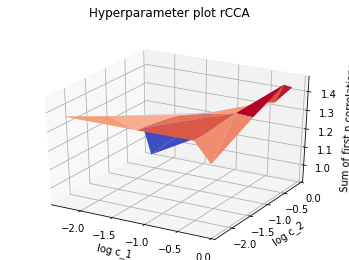

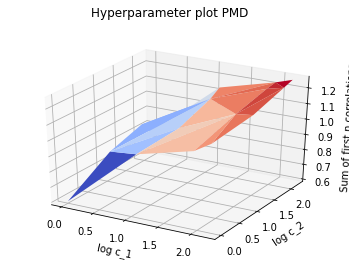

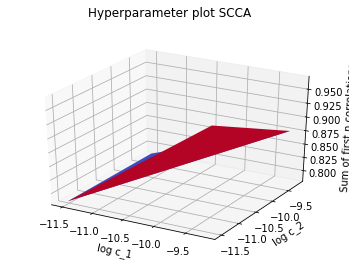

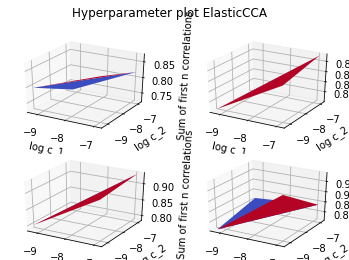

In [11]:
from cca_zoo.models import rCCA, PMD,SCCA,ElasticCCA
"""
### Ridge CCA (can pass more than 2 views)
"""
c1 = [0.1, 0.3, 0.7, 0.9]
c2 = [0.1, 0.3, 0.7, 0.9]
param_candidates = {'c': list(itertools.product(c1, c2))}

ridge = rCCA(latent_dims=latent_dims).gridsearch_fit(
    train_view_1,
    train_view_2,
    param_candidates=param_candidates,
    folds=cv_folds,
    verbose=True, jobs=jobs,
    plot=True)

ridge_results = np.stack((ridge.train_correlations[0, 1, :], ridge.predict_corr(test_view_1, test_view_2)[0, 1, :]))

"""
### Sparse CCA (Penalized Matrix Decomposition) (can pass more than 2 views)
"""

# PMD
c1 = [1, 3, 7, 9]
c2 = [1, 3, 7, 9]
param_candidates = {'c': list(itertools.product(c1, c2))}

pmd = PMD(latent_dims=latent_dims, max_iter=max_iter).gridsearch_fit(
    train_view_1,
    train_view_2,
    param_candidates=param_candidates,
    folds=cv_folds,
    verbose=True, jobs=jobs,
    plot=True)

pmd_results = np.stack((pmd.train_correlations[0, 1, :], pmd.predict_corr(test_view_1, test_view_2)[0, 1, :]))

"""
### Sparse CCA (can pass more than 2 views)
"""

# Sparse CCA
c1 = [0.00001, 0.0001]
c2 = [0.00001, 0.0001]
param_candidates = {'c': list(itertools.product(c1, c2))}

scca = SCCA(latent_dims=latent_dims, max_iter=max_iter).gridsearch_fit(
    train_view_1,
    train_view_2,
    param_candidates=param_candidates,
    folds=cv_folds,
    verbose=True,
    jobs=jobs, plot=True)

scca_results = np.stack(
    (scca.train_correlations[0, 1, :], scca.predict_corr(test_view_1, test_view_2)[0, 1, :]))


"""
### Elastic CCA (can pass more than 2 views)
"""

# Elastic CCA
c1 = [0.001, 0.0001]
c2 = [0.001, 0.0001]
l1_1 = [0.01, 0.1]
l1_2 = [0.01, 0.1]
param_candidates = {'c': list(itertools.product(c1, c2)), 'l1_ratio': list(itertools.product(l1_1, l1_2))}

elastic = ElasticCCA(latent_dims=latent_dims,
                              max_iter=max_iter).gridsearch_fit(train_view_1,
                                                                train_view_2,
                                                                param_candidates=param_candidates,
                                                                folds=cv_folds,
                                                                verbose=True,
                                                                jobs=jobs,
                                                                plot=True)

elastic_results = np.stack(
    (elastic.train_correlations[0, 1, :], elastic.predict_corr(test_view_1, test_view_2)[0, 1, :]))

# Kernel CCA

cross validation
number of folds:  5
Best score :  1.4420676375878017
Standard deviation :  0.07505838198366332
{'kernel': ['linear', 'linear'], 'c': (0.99, 0.99)}
cross validation
number of folds:  5
Best score :  0.9367852577645979
Standard deviation :  0.0829977546021042
{'kernel': ['poly', 'poly'], 'degree': (2, 3), 'c': (0.9, 0.9)}
cross validation
number of folds:  5
Best score :  3.549006669510048e-225
Standard deviation :  0.0
{'kernel': ['rbf', 'rbf'], 'gamma': (10.0, 10.0), 'c': (0.9, 0.99)}


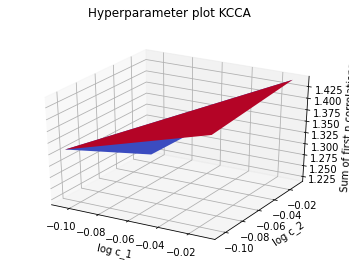

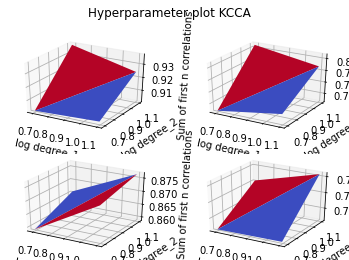

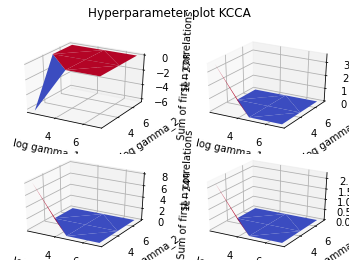

In [4]:
from cca_zoo.models import KCCA
"""
### Kernel CCA

Similarly, we can use kernel CCA methods with [method='kernel']

We can use different kernels and their associated parameters in a similar manner to before
- regularized linear kernel CCA: parameters :  'kernel'='linear', 0<'c'<1
- polynomial kernel CCA: parameters : 'kernel'='poly', 'degree', 0<'c'<1
- gaussian rbf kernel CCA: parameters : 'kernel'='gaussian', 'sigma', 0<'c'<1
"""
# %%
# r-kernel cca
c1 = [0.9, 0.99]
c2 = [0.9, 0.99]

param_candidates = {'kernel': [['linear', 'linear']], 'c': list(itertools.product(c1, c2))}

kernel_reg = KCCA(latent_dims=latent_dims).gridsearch_fit(train_view_1, train_view_2,
                                                          folds=cv_folds,
                                                          param_candidates=param_candidates,
                                                          verbose=True, jobs=jobs,
                                                          plot=True)
kernel_reg_results = np.stack((
    kernel_reg.train_correlations[0, 1, :],
    kernel_reg.predict_corr(test_view_1, test_view_2)[0, 1, :]))

# kernel cca (poly)
degree1 = [2, 3]
degree2 = [2, 3]

param_candidates = {'kernel': [['poly', 'poly']], 'degree': list(itertools.product(degree1, degree2)),
                    'c': list(itertools.product(c1, c2))}

kernel_poly = KCCA(latent_dims=latent_dims).gridsearch_fit(train_view_1, train_view_2,
                                                           folds=cv_folds,
                                                           param_candidates=param_candidates,
                                                           verbose=True, jobs=jobs,
                                                           plot=True)

kernel_poly_results = np.stack((
    kernel_poly.train_correlations[0, 1, :],
    kernel_poly.predict_corr(test_view_1, test_view_2)[0, 1, :]))

# kernel cca (gaussian)
gamma1 = [1e+1, 1e+2, 1e+3]
gamma2 = [1e+1, 1e+2, 1e+3]

param_candidates = {'kernel': [['rbf', 'rbf']], 'gamma': list(itertools.product(gamma1, gamma2)),
                    'c': list(itertools.product(c1, c2))}

kernel_gaussian = KCCA(latent_dims=latent_dims).gridsearch_fit(train_view_1, train_view_2,
                                                               folds=cv_folds,
                                                               param_candidates=param_candidates,
                                                               verbose=True, jobs=jobs,
                                                               plot=True)

kernel_gaussian_results = np.stack((
    kernel_gaussian.train_correlations[0, 1, :],
    kernel_gaussian.predict_corr(test_view_1, test_view_2)[0, 1, :]))

# Deep CCA

DCCA can be optimized using Andrew's original tracenorm objective or Wang's DCCA by nonlinear orthogonal iterations using the argument als=True.

In [ ]:
"""
### Deep Learning

We also have deep CCA methods (and autoencoder variants)
- Deep CCA (DCCA)
- Deep Canonically Correlated Autoencoders (DCCAE)

We introduce a Config class from configuration.py. This contains a number of default settings for running DCCA.

"""
from cca_zoo.deepmodels import Dee

# %%
# DCCA
print('DCCA')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
dcca_model = DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2])

dcca_model = DeepWrapper(dcca_model)

dcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dcca_results = np.stack((dcca_model.train_correlations[0, 1], dcca_model.predict_corr(test_dataset)[0, 1]))


from cca_zoo import dcca_noi
# DCCA_NOI
# Note that als=True
print('DCCA by non-linear orthogonal iterations')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
dcca_noi_model = dcca_noi.DCCA_NOI(latent_dims=latent_dims, encoders=[encoder_1, encoder_2])

dcca_noi_model = deepwrapper.DeepWrapper(dcca_noi_model)

dcca_noi_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dcca_noi_results = np.stack(
    (dcca_noi_model.train_correlations[0, 1], dcca_noi_model.predict_corr(test_dataset)[0, 1]))

DCCA
total parameters:  201476


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:936: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


====> Epoch: 1 Average train loss: -0.2801
====> Epoch: 1 Average val loss: -0.7396
Min loss -0.74
====> Epoch: 2 Average train loss: -0.6931
====> Epoch: 2 Average val loss: -0.9382
Min loss -0.94
====> Epoch: 3 Average train loss: -0.9064
====> Epoch: 3 Average val loss: -1.0791
Min loss -1.08
====> Epoch: 4 Average train loss: -1.1217
====> Epoch: 4 Average val loss: -1.1549
Min loss -1.15
====> Epoch: 5 Average train loss: -1.1235
====> Epoch: 5 Average val loss: -1.2832
Min loss -1.28
====> Epoch: 6 Average train loss: -1.1602
====> Epoch: 6 Average val loss: -1.1615
====> Epoch: 7 Average train loss: -1.2731
====> Epoch: 7 Average val loss: -1.2787
====> Epoch: 8 Average train loss: -1.2215
====> Epoch: 8 Average val loss: -1.2810
====> Epoch: 9 Average train loss: -1.2851
====> Epoch: 9 Average val loss: -1.2833
Min loss -1.28
====> Epoch: 10 Average train loss: -1.2556
====> Epoch: 10 Average val loss: -1.2792
====> Epoch: 11 Average train loss: -1.2700
====> Epoch: 11 Average 

# DCCA with custom optimizers and schedulers

In [ ]:
# DCCA
optimizers = [optim.Adam(encoder_1.parameters(), lr=1e-4), optim.Adam(encoder_2.parameters(), lr=1e-4)]
schedulers = [optim.lr_scheduler.CosineAnnealingLR(optimizers[0], 1),
              optim.lr_scheduler.ReduceLROnPlateau(optimizers[1])]
dcca_model = dcca.DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2],
                                objective=objectives.CCA, optimizers=optimizers, schedulers=schedulers)
# hidden_layer_sizes are shown explicitly but these are also the defaults
dcca_model = deepwrapper.DeepWrapper(dcca_model)
dcca_model.fit(train_dataset, val_dataset=val_dataset,epochs=20)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:936: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


total parameters:  201476
====> Epoch: 1 Average train loss: -0.0069
====> Epoch: 1 Average val loss: -0.0096
Min loss -0.01
====> Epoch: 2 Average train loss: -0.0098
====> Epoch: 2 Average val loss: -0.0104
Min loss -0.01
====> Epoch: 3 Average train loss: -0.0113
====> Epoch: 3 Average val loss: -0.0143
Min loss -0.01
====> Epoch: 4 Average train loss: -0.0127
====> Epoch: 4 Average val loss: -0.0165
Min loss -0.02
====> Epoch: 5 Average train loss: -0.0164
====> Epoch: 5 Average val loss: -0.0204
Min loss -0.02
====> Epoch: 6 Average train loss: -0.0207
====> Epoch: 6 Average val loss: -0.0222
Min loss -0.02
====> Epoch: 7 Average train loss: -0.0256
====> Epoch: 7 Average val loss: -0.0270
Min loss -0.03
====> Epoch: 8 Average train loss: -0.0264
====> Epoch: 8 Average val loss: -0.0319
Min loss -0.03
====> Epoch: 9 Average train loss: -0.0345
====> Epoch: 9 Average val loss: -0.0286
====> Epoch: 10 Average train loss: -0.0320
====> Epoch: 10 Average val loss: -0.0386
Min loss -0.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


DeepWrapper(device='cpu',
            model=DCCA(
  (encoders): ModuleList(
    (0): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Linear(in_features=784, out_features=128, bias=True)
          (1): ReLU()
        )
      )
      (fc): Linear(in_features=128, out_features=2, bias=True)
    )
    (1): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Linear(in_features=784, out_features=128, bias=True)
          (1): ReLU()
        )
      )
      (fc): Linear(in_features=128, out_features=2, bias=True)
    )
  )
),
            tensorboard=False, tensorboard_tag=None)

# DGCCA and DMCCA for more than 2 views

The only change we need to make is to the objective argument to perform DGCCA and DMCCA.

In [ ]:
# DGCCA
print('DGCCA')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
dgcca_model = dcca.DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], objective=objectives.GCCA)

dgcca_model = deepwrapper.DeepWrapper(dgcca_model)

dgcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dgcca_results = np.stack(
    (dgcca_model.train_correlations[0, 1], dgcca_model.predict_corr(test_dataset)[0, 1]))

# DMCCA
print('DMCCA')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
dmcca_model = dcca.DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], objective=objectives.MCCA)

dmcca_model = deepwrapper.DeepWrapper(dmcca_model)

dmcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dmcca_results = np.stack(
    (dmcca_model.train_correlations[0, 1], dmcca_model.predict_corr(test_dataset)[0, 1]))

DGCCA
total parameters:  201476


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:936: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


====> Epoch: 1 Average train loss: -0.0942
====> Epoch: 1 Average val loss: -0.7712
Min loss -0.77
====> Epoch: 2 Average train loss: -0.9046
====> Epoch: 2 Average val loss: -1.1785
Min loss -1.18
====> Epoch: 3 Average train loss: -1.1812
====> Epoch: 3 Average val loss: -1.2140
Min loss -1.21
====> Epoch: 4 Average train loss: -1.2060
====> Epoch: 4 Average val loss: -1.2871
Min loss -1.29
====> Epoch: 5 Average train loss: -1.2845
====> Epoch: 5 Average val loss: -1.3248
Min loss -1.32
====> Epoch: 6 Average train loss: -1.3221
====> Epoch: 6 Average val loss: -1.3468
Min loss -1.35
====> Epoch: 7 Average train loss: -1.3360
====> Epoch: 7 Average val loss: -1.3763
Min loss -1.38
====> Epoch: 8 Average train loss: -1.3667
====> Epoch: 8 Average val loss: -1.2920
====> Epoch: 9 Average train loss: -1.3541
====> Epoch: 9 Average val loss: -1.3590
====> Epoch: 10 Average train loss: -1.3587
====> Epoch: 10 Average val loss: -1.3665
====> Epoch: 11 Average train loss: -1.4102
====> Epo

# Deep Canonically Correlated Autoencoders
We need to add decoders in order to model deep canonically correlated autoencoders and we also use the DCCAE class which inherits from DCCA

In [ ]:
from cca_zoo import dccae

# DCCAE
print('DCCAE')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
decoder_1 = deep_models.Decoder(latent_dims=latent_dims, feature_size=784)
decoder_2 = deep_models.Decoder(latent_dims=latent_dims, feature_size=784)
dccae_model = dccae.DCCAE(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], decoders=[decoder_1, decoder_2])

dccae_model = deepwrapper.DeepWrapper(dccae_model)

#can also pass a tuple of numpy arrays
dccae_model.fit((train_view_1, train_view_2), epochs=epochs)

dccae_results = np.stack(
    (dccae_model.train_correlations[0, 1], dccae_model.predict_corr(test_dataset)[0, 1]))

DCCAE
total parameters:  404516
====> Epoch: 1 Average train loss: 54437.5664
====> Epoch: 1 Average val loss: 11212.0869
Min loss 11212.09
====> Epoch: 2 Average train loss: 45825.0508
====> Epoch: 2 Average val loss: 9642.8906
Min loss 9642.89
====> Epoch: 3 Average train loss: 39497.9688
====> Epoch: 3 Average val loss: 8547.5625
Min loss 8547.56
====> Epoch: 4 Average train loss: 35070.7930
====> Epoch: 4 Average val loss: 7814.0234
Min loss 7814.02
====> Epoch: 5 Average train loss: 32095.4863
====> Epoch: 5 Average val loss: 7340.1987
Min loss 7340.20
====> Epoch: 6 Average train loss: 30163.4785
====> Epoch: 6 Average val loss: 7048.8726
Min loss 7048.87
====> Epoch: 7 Average train loss: 28966.8574
====> Epoch: 7 Average val loss: 6882.0151
Min loss 6882.02
====> Epoch: 8 Average train loss: 28274.3203
====> Epoch: 8 Average val loss: 6794.5645
Min loss 6794.56
====> Epoch: 9 Average train loss: 27904.0176
====> Epoch: 9 Average val loss: 6751.9502
Min loss 6751.95
====> Epoch:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:936: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


# Deep Variational CCA

In [ ]:
"""
### Deep Variational Learning
Finally we have Deep Variational CCA methods.
- Deep Variational CCA (DVCCA)
- Deep Variational CCA - private (DVVCA_p)

These are both implemented by the DVCCA class with private=True/False and both_encoders=True/False. If both_encoders,
the encoder to the shared information Q(z_shared|x) is modelled for both x_1 and x_2 whereas if both_encoders is false
it is modelled for x_1 as in the paper
"""
from cca_zoo import dvcca

# %%
# DVCCA (technically bi-DVCCA)
print('DVCCA')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
decoder_1 = deep_models.Decoder(latent_dims=latent_dims, feature_size=784, norm_output=True)
decoder_2 = deep_models.Decoder(latent_dims=latent_dims, feature_size=784, norm_output=True)
dvcca_model = dvcca.DVCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], decoders=[decoder_1, decoder_2],
                          private=False)

dvcca_model = deepwrapper.DeepWrapper(dvcca_model)

dvcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dvcca_model_results = np.stack(
    (dvcca_model.train_correlations[0, 1], dvcca_model.predict_corr(test_dataset)[0, 1]))

# DVCCA_private (technically bi-DVCCA_private)
print('DVCCA_private')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
private_encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
private_encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
decoder_1 = deep_models.Decoder(latent_dims=latent_dims * 2, feature_size=784, norm_output=True)
decoder_2 = deep_models.Decoder(latent_dims=latent_dims * 2, feature_size=784, norm_output=True)
dvccap_model = dvcca.DVCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], decoders=[decoder_1, decoder_2],
                           private_encoders=[private_encoder_1, private_encoder_2], private=True)

dvccap_model = deepwrapper.DeepWrapper(dvccap_model)

dvccap_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dvccap_model_results = np.stack(
    (dvccap_model.train_correlations[0, 1], dvccap_model.predict_corr(test_dataset)[0, 1]))

DVCCA
total parameters:  405032


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:936: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


====> Epoch: 1 Average train loss: 1102.2251
====> Epoch: 1 Average val loss: 1080.9238
Min loss 1080.92
====> Epoch: 2 Average train loss: 1080.6416
====> Epoch: 2 Average val loss: 1061.2964
Min loss 1061.30
====> Epoch: 3 Average train loss: 1060.2611
====> Epoch: 3 Average val loss: 1042.7833
Min loss 1042.78
====> Epoch: 4 Average train loss: 1042.7712
====> Epoch: 4 Average val loss: 1025.0345
Min loss 1025.03
====> Epoch: 5 Average train loss: 1026.2625
====> Epoch: 5 Average val loss: 1011.1165
Min loss 1011.12
====> Epoch: 6 Average train loss: 1009.3911
====> Epoch: 6 Average val loss: 995.5959
Min loss 995.60
====> Epoch: 7 Average train loss: 995.2148
====> Epoch: 7 Average val loss: 983.6167
Min loss 983.62
====> Epoch: 8 Average train loss: 981.9344
====> Epoch: 8 Average val loss: 971.5005
Min loss 971.50
====> Epoch: 9 Average train loss: 968.9379
====> Epoch: 9 Average val loss: 960.5873
Min loss 960.59
====> Epoch: 10 Average train loss: 959.9377
====> Epoch: 10 Avera

# Convolutional Deep CCA (and using other architectures)
We provide a standard CNN encoder and decoder but users can build their own encoders and decoders by inheriting BaseEncoder and BaseDecoder for seamless integration with the pipeline

In [ ]:
print('Convolutional DCCA')
encoder_1 = deep_models.CNNEncoder(latent_dims=latent_dims, channels=[3, 3])
encoder_2 = deep_models.CNNEncoder(latent_dims=latent_dims, channels=[3, 3])
dcca_conv_model = dcca.DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2])

dcca_conv_model = deepwrapper.DeepWrapper(dcca_conv_model)

# to change the models used change the cfg.encoder_models. We implement a CNN_Encoder and CNN_decoder as well
# as some based on brainnet architecture in cca_zoo.deep_models. Equally you could pass your own encoder/decoder models

dcca_conv_model.fit((train_view_1.reshape((-1, 1, 28, 28)), train_view_2.reshape((-1, 1, 28, 28))), epochs=epochs)

dcca_conv_results = np.stack(
    (dcca_conv_model.train_correlations[0, 1], dcca_conv_model.predict_corr((test_view_1.reshape((-1, 1, 28, 28)),
                                                                            test_view_2.reshape(
                                                                                (-1, 1, 28, 28))))[0, 1]))

Convolutional DCCA
total parameters:  9568
====> Epoch: 1 Average train loss: -0.3282
====> Epoch: 1 Average val loss: -0.6592
Min loss -0.66
====> Epoch: 2 Average train loss: -0.9536
====> Epoch: 2 Average val loss: -0.9541
Min loss -0.95
====> Epoch: 3 Average train loss: -1.2399
====> Epoch: 3 Average val loss: -1.0962
Min loss -1.10
====> Epoch: 4 Average train loss: -1.3620
====> Epoch: 4 Average val loss: -1.1773
Min loss -1.18
====> Epoch: 5 Average train loss: -1.4348
====> Epoch: 5 Average val loss: -1.2338
Min loss -1.23
====> Epoch: 6 Average train loss: -1.4889
====> Epoch: 6 Average val loss: -1.2784
Min loss -1.28
====> Epoch: 7 Average train loss: -1.5335
====> Epoch: 7 Average val loss: -1.3157
Min loss -1.32
====> Epoch: 8 Average train loss: -1.5716
====> Epoch: 8 Average val loss: -1.3480
Min loss -1.35
====> Epoch: 9 Average train loss: -1.6045
====> Epoch: 9 Average val loss: -1.3759
Min loss -1.38
====> Epoch: 10 Average train loss: -1.6324
====> Epoch: 10 Averag

# DTCCA

In [ ]:
from cca_zoo import dtcca

# %%
# DTCCA
print('DTCCA')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
dtcca_model = dtcca.DTCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2])

dtcca_model = deepwrapper.DeepWrapper(dtcca_model)

dtcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dtcca_results = np.stack((dtcca_model.train_correlations[0, 1], dtcca_model.predict_corr(test_dataset)[0, 1]))

DTCCA
total parameters:  201476


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:936: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


====> Epoch: 1 Average train loss: 0.0000
====> Epoch: 1 Average val loss: 0.0000
Min loss 0.00
====> Epoch: 2 Average train loss: 0.0000
====> Epoch: 2 Average val loss: 0.0000
Min loss 0.00
====> Epoch: 3 Average train loss: 0.0000
====> Epoch: 3 Average val loss: 0.0000
====> Epoch: 4 Average train loss: 0.0000
====> Epoch: 4 Average val loss: 0.0000
====> Epoch: 5 Average train loss: 0.0000
====> Epoch: 5 Average val loss: 0.0000
====> Epoch: 6 Average train loss: 0.0000
====> Epoch: 6 Average val loss: 0.0000
====> Epoch: 7 Average train loss: 0.0000
====> Epoch: 7 Average val loss: 0.0000
====> Epoch: 8 Average train loss: 0.0000
====> Epoch: 8 Average val loss: 0.0000
====> Epoch: 9 Average train loss: 0.0000
====> Epoch: 9 Average val loss: 0.0000
====> Epoch: 10 Average train loss: 0.0000
====> Epoch: 10 Average val loss: 0.0000
====> Epoch: 11 Average train loss: 0.0000
====> Epoch: 11 Average val loss: 0.0000
====> Epoch: 12 Average train loss: 0.0000
====> Epoch: 12 Average

/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:2832: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


# Generate Some Plots

In [ ]:
"""
### Make results plot to compare methods
"""
# %%

all_results = np.stack(
    [linear_cca_results, gcca_results, mcca_results, pls_results, pmd_results, elastic_results,
     scca_results, kernel_reg_results, kernel_poly_results,
     kernel_gaussian_results, dcca_results, dgcca_results, dmcca_results, dvcca_model_results,
     dcca_conv_results, dtcca_results],
    axis=0)
all_labels = ['linear', 'gcca', 'mcca', 'pls', 'pmd', 'elastic', 'scca', 'linear kernel', 'polynomial kernel',
              'gaussian kernel', 'deep CCA', 'deep generalized CCA', 'deep multiset CCA', 'deep VCCA',
              'deep convolutional cca', 'DTCCA']

from cca_zoo import plot_utils

plot_utils.plot_results(all_results, all_labels)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/